In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

### 1. Accuracy - Loss

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.37, Prune Accuracy: 97.92, Sparsity: 66.80
Epoch: 20. Test Accuracy: 98.31, Prune Accuracy: 94.94, Sparsity: 96.41
Epoch: 30. Test Accuracy: 97.90, Prune Accuracy: 97.46, Sparsity: 97.02
Epoch: 40. Test Accuracy: 98.12, Prune Accuracy: 97.56, Sparsity: 97.02
Epoch: 50. Test Accuracy: 98.09, Prune Accuracy: 97.75, Sparsity: 97.02
Retrain Test: 98.09, Prune Test: 97.75, Prune Sparsity: 97.02


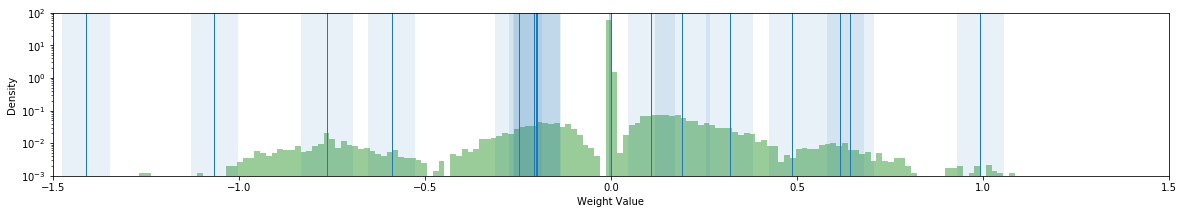

In [9]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1e-5, 5, 16, "LeNet_300_100", "full", 'CEST', False, "./files")
show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

### 2. Gamma Prior Variance

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.47, Prune Accuracy: 98.43, Sparsity: 58.93
Epoch: 20. Test Accuracy: 98.47, Prune Accuracy: 98.34, Sparsity: 67.74
Epoch: 30. Test Accuracy: 98.49, Prune Accuracy: 98.16, Sparsity: 73.13
Epoch: 40. Test Accuracy: 98.50, Prune Accuracy: 98.30, Sparsity: 78.70
Epoch: 50. Test Accuracy: 98.43, Prune Accuracy: 98.21, Sparsity: 82.78
Retrain Test: 98.43, Prune Test: 98.21, Prune Sparsity: 82.78


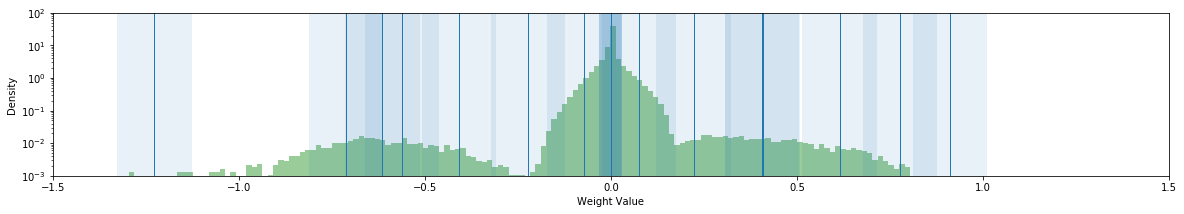

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 1.0
Epoch: 10. Test Accuracy: 98.48, Prune Accuracy: 98.33, Sparsity: 58.83
Epoch: 20. Test Accuracy: 98.46, Prune Accuracy: 98.35, Sparsity: 68.00
Epoch: 30. Test Accuracy: 98.42, Prune Accuracy: 98.06, Sparsity: 73.91
Epoch: 40. Test Accuracy: 98.49, Prune Accuracy: 98.01, Sparsity: 76.75
Epoch: 50. Test Accuracy: 98.45, Prune Accuracy: 97.76, Sparsity: 79.47
Retrain Test: 98.45, Prune Test: 97.76, Prune Sparsity: 79.47


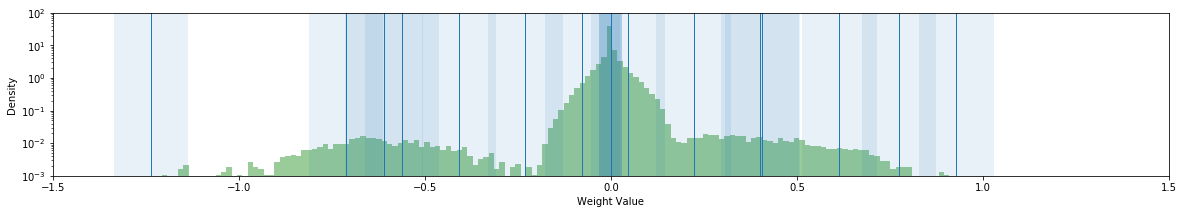

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.44, Prune Accuracy: 98.31, Sparsity: 59.00
Epoch: 20. Test Accuracy: 98.44, Prune Accuracy: 98.50, Sparsity: 68.57
Epoch: 30. Test Accuracy: 98.45, Prune Accuracy: 98.15, Sparsity: 73.73
Epoch: 40. Test Accuracy: 98.45, Prune Accuracy: 98.20, Sparsity: 76.87
Epoch: 50. Test Accuracy: 98.41, Prune Accuracy: 98.09, Sparsity: 79.88
Retrain Test: 98.41, Prune Test: 98.09, Prune Sparsity: 79.88


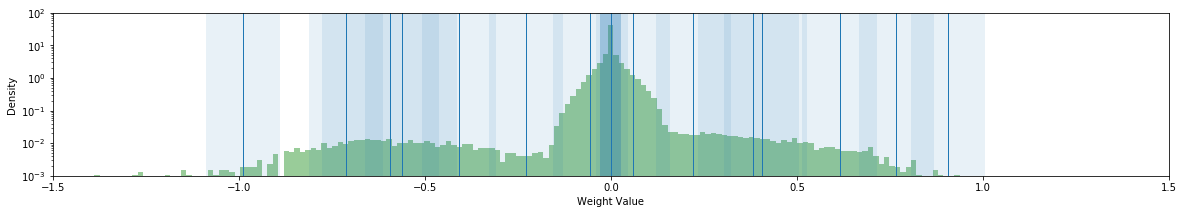

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 100.0
Epoch: 10. Test Accuracy: 98.48, Prune Accuracy: 98.33, Sparsity: 59.63
Epoch: 20. Test Accuracy: 98.47, Prune Accuracy: 98.44, Sparsity: 67.75
Epoch: 30. Test Accuracy: 98.49, Prune Accuracy: 98.10, Sparsity: 71.77
Epoch: 40. Test Accuracy: 98.38, Prune Accuracy: 98.13, Sparsity: 75.56
Epoch: 50. Test Accuracy: 98.50, Prune Accuracy: 98.09, Sparsity: 77.57
Retrain Test: 98.50, Prune Test: 98.09, Prune Sparsity: 77.57


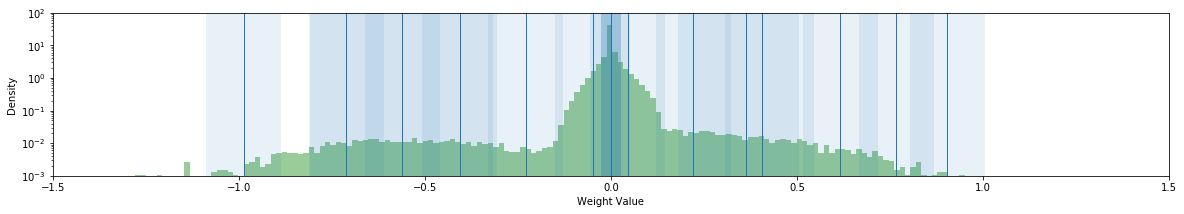

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 999.9999999999998


In [ ]:
vlist = [0.1, 1, 10, 100, 1000]
zvar = 1250
for var in vlist:
    fn_text = "_var_{}_zvar_{}".format(var,zvar)
    model, gmp, res = retrain_model(100, var, 2500, zvar, 1e-6, 5, 15, "LeNet_300_100", "full", 'CEST', False, "./files", fn = fn_text)
    show_sws_weights_log(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))